In [1]:
import os, random
from os import path
from numpy.random import seed
import keras
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from distutils.dir_util import copy_tree
import shutil
from PIL import Image
from keras import layers,models
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import ParameterGrid
from tensorflow import random as tfrandom
import tensorflow as tf
from keras.callbacks import Callback, CSVLogger
import time
from keras.models import load_model
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
from keras import backend as K
import math
#from tensorflow import set_random_seed
import cv2

# to assure reproducibility
random.seed(42)
tf.random.set_seed(42)

In [2]:
base_path=os.getcwd()

In [3]:
base_path

'c:\\Users\\Utilizador\\Desktop\\2_semestre_DS\\Deep_Learning\\DL_GroupProject\\DeepLearning_Group_Project'

In [4]:
dir_path=(base_path+r"\tumor_data")

In [28]:
# rename the images to 1_xx, 2_xx, 3_xx, by the labels 

for _, letter in enumerate(os.listdir(dir_path)):
    folder_letter = os.path.join(dir_path, letter)
 
    counts=0
    for _, image in enumerate(os.listdir(folder_letter)):
        
        dst=image
    
        if '_' in dst:
            continue
        else:
            dst = str(letter) + "_" + str(counts) + ".png"
            #print(dst)
            src = os.path.join(folder_letter, image)
            dst = os.path.join(folder_letter, dst)
            print(counts)
            os.rename(src, dst)
            
        counts=counts+1
        

In [5]:
# define directories for the train, val and test splits
train_path = os.path.join(dir_path, 'train')
val_path = os.path.join(dir_path, 'validation')
test_path = os.path.join(dir_path, 'test')

In [30]:
def createdir(mydir):
    try:
        os.mkdir(mydir)
    except OSError:
        pass

# create the directories

createdir(train_path)
createdir(val_path)
createdir(test_path)

In [31]:
# create the directories for each label for each train, validation and test folders
count=0
for dir in [train_path, val_path, test_path]:
    count+=1
    for letter in ['1','2','3']:
        if count == 1:
            createdir(os.path.join(dir,str("train_{0}".format(str(letter)))))
        elif count == 2:
            createdir(os.path.join(dir,str("val_{0}".format(str(letter)))))   
        elif count == 3:
            createdir(os.path.join(dir,str("test_{0}".format(str(letter)))))
        

In [32]:
# copy all the images for the train folder to then split them for validation and test folders 

count=0

for dir_ in [train_path+r'\train_1', train_path+r'\train_2', train_path+r'\train_3']:
        if len(os.listdir(dir_)) != 0:
            print('break')
            for f in os.listdir(dir_):
                os.remove(os.path.join(dir_, f))
                
for dir in [dir_path+r"\1", dir_path+r"\2", dir_path+r"\3"]:
    count+=1
    
    if count == 1:
        copy_tree(dir, train_path+r'\train_1')
    elif count==2:
        copy_tree(dir, train_path+r'\train_2')
    elif count==3:
        copy_tree(dir, train_path+r'\train_3')

break
break
break


In [6]:
# proportion we want for train, val_test and the test datasets
prop_train=0.80
prop_val_test=0.20
prop_test=0.50 

In [34]:
labels={'label1':708,'label2':1426,'label3':930}

In [35]:
# input images in VALIDATION

count=0
for index, letter in enumerate(os.listdir(train_path)):
    count+=1
    folder_letter_source = os.path.join(train_path, letter)
    folder_letter_destiny_val = os.path.join(val_path, str("val_{0}".format(str(count))))

    images_val = random.sample(os.listdir(folder_letter_source), k=round(prop_val_test*labels['label{0}'.format(str(count))]))
    count1=0
    
    for image in images_val:
        count1+=1
        if count1==1 and len(os.listdir(folder_letter_destiny_val)) != 0:
            print('break')
            for f in os.listdir(folder_letter_destiny_val):
                os.remove(os.path.join(folder_letter_destiny_val, f))
            
        src = os.path.join(folder_letter_source, image)
        dst = os.path.join(folder_letter_destiny_val, image)
        shutil.move(src, dst)


break
break
break


In [36]:
labels['label1']=round(labels['label1']*prop_val_test)
labels['label2']=round(labels['label2']*prop_val_test)
labels['label3']=round(labels['label3']*prop_val_test)
labels

{'label1': 142, 'label2': 285, 'label3': 186}

In [37]:
# input images in TEST

count=0
for index, letter in enumerate(os.listdir(val_path)):
    count+=1
    folder_letter_source = os.path.join(val_path, letter)
    folder_letter_destiny_test = os.path.join(test_path, str("test_{0}".format(str(count))))

    images_val = random.sample(os.listdir(folder_letter_source), k=round(prop_test*labels['label{0}'.format(str(count))]))
    count1=0
    
    for image in images_val:
        count1+=1
        if count1==1 and len(os.listdir(folder_letter_destiny_test)) != 0:
            print('break')
            for f in os.listdir(folder_letter_destiny_test):
                os.remove(os.path.join(folder_letter_destiny_test, f))
            
        src = os.path.join(folder_letter_source, image)
        dst = os.path.join(folder_letter_destiny_test, image)
        shutil.move(src, dst)
        

break
break
break


In [10]:
train_datagen_aug=ImageDataGenerator(
                    rescale=1./255,
                    #rotation_range=50,
                    rotation_range=10,
                    shear_range=0.05)
                    #horizontal_flip=True )

train_generator_aug = train_datagen_aug.flow_from_directory(
    train_path,
    target_size=(150, 150),
    batch_size=20,
    class_mode='categorical',
    color_mode='grayscale',
    seed=42
)

Found 2451 images belonging to 3 classes.


In [11]:
train_datagen = ImageDataGenerator(rescale=1.0/255.0)
val_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(150, 150),
    batch_size=20,
    class_mode='categorical',
    color_mode='grayscale',
    seed=42
)

val_generator = val_datagen.flow_from_directory(
    val_path,
    target_size=(150, 150),  
    batch_size=20,
    class_mode='categorical',
    color_mode='grayscale',
    seed=42
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(150, 150), 
    batch_size=20,
    class_mode='categorical',
    color_mode='grayscale',
    seed=42,
    shuffle=False
)

Found 2451 images belonging to 3 classes.
Found 307 images belonging to 3 classes.
Found 306 images belonging to 3 classes.


In [12]:
train_generator_rgb = train_datagen.flow_from_directory(
    train_path,
    target_size=(150, 150),
    batch_size=20,
    class_mode='categorical',
    color_mode='rgb',
    seed=42
)
# AUGMENTED
train_generator_aug_rgb = train_datagen_aug.flow_from_directory(
    train_path,
    target_size=(150, 150),
    batch_size=20,
    class_mode='categorical',
    color_mode='rgb',
    seed=42
)


val_generator_rgb = val_datagen.flow_from_directory(
    val_path,
    target_size=(150, 150),  
    batch_size=20,
    class_mode='categorical',
    color_mode='rgb',
    seed=42
)

test_generator_rgb = test_datagen.flow_from_directory(
    test_path,
    target_size=(150, 150), 
    batch_size=20,
    class_mode='categorical',
    color_mode='rgb',
    seed=42,
    shuffle=False
)

Found 2451 images belonging to 3 classes.
Found 2451 images belonging to 3 classes.
Found 307 images belonging to 3 classes.
Found 306 images belonging to 3 classes.


In [13]:
# ADAPTED FROM https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [14]:
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

time_callback = TimeHistory()

In [15]:
def save_times(model, times,name_model):
  
    times_dict = {'Model': ['Model {}'.format(str(name_model))]}
    for idx, time in enumerate(times):
        times_dict[idx] = times[idx]
    df_save_times = pd.DataFrame(times_dict)

    if os.path.exists(r'.\models\models_times.csv'):
        df_save_times.to_csv(r'.\models\models_times.csv', mode='a', header=False, index=False)
    else:
        df_save_times.to_csv(r'.\models\models_times.csv')

In [16]:
def plot_history(his):
    f1 = his['f1_m']
    f1_val=his['val_f1_m']
    loss = his['loss']
    loss_val=his['val_loss']

    epochs=range(1,len(f1)+1)

    plt.plot(epochs, f1,'bo',label='Training F1')
    plt.plot(epochs, f1_val,'b',label='Validation F1')
    plt.title('Training and Validation F1 score')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss,'bo',label='Training loss')
    plt.plot(epochs, loss_val,'b',label='Validation loss')
    plt.title('Training and Validation loss')
    plt.legend()
    plt.figure()

In [17]:
def callback(filename):
  callname_list=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=4),
            keras.callbacks.ModelCheckpoint(filepath=os.path.join(base_path+ "\models")+filename, monitor='val_loss',mode='min',verbose=1, save_best_only=True)
            ,time_callback]

  return callname_list


In [18]:
dependencies = {
    'f1_m': f1_m
}

In [26]:
BATCH_SIZE=20 
TRAINING_SIZE = 2451 
VALIDATION_SIZE = 307 

compute_steps_per_epoch = lambda x: int(math.ceil(1. * x / BATCH_SIZE)) 
steps_per_epoch = compute_steps_per_epoch(TRAINING_SIZE) 
val_steps = compute_steps_per_epoch(VALIDATION_SIZE) 

print(steps_per_epoch)
print(val_steps)

123
16


In [29]:
callbacks_BW = callback("\modelBW.h5")

In [30]:
model = models.Sequential()

model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Flatten())
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[f1_m])

history_1st = model.fit_generator(train_generator, callbacks=callbacks_BW, epochs=30, steps_per_epoch=123, validation_steps=16,
                                 validation_data=val_generator, workers=2)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
123/123 [==============================] - ETA: 0s - loss: 0.8207 - f1_m: 0.4929
Epoch 00001: val_loss improved from inf to 0.66708, saving model to c:\Users\Utilizador\Desktop\2_semestre_DS\Deep_Learning\DL_GroupProject\DeepLearning_Group_Project\models\modelBW.h5
123/123 [==============================] - 109s 888ms/step - loss: 0.8207 - f1_m: 0.4929 - val_loss: 0.6671 - val_f1_m: 0.6100
Epoch 2/30
123/123 [==============================] - ETA: 0s - loss: 0.6018 - f1_m: 0.7187
Epoch 00002: val_loss improved from 0.66708 to 0.54838, saving model to c:\Users\Utilizador\Desktop\2_semestre_DS\Deep_Learning\DL_GroupProject\DeepLearning_Group_Project\models\modelBW.h5
123/123 [==============================] - 112s 913ms/step - loss: 0.6018 - f1_m: 0.7187 - val_loss: 0.5484 - val_f1_m: 0.7464
Epoch 3/30
123/123 [==============================] - ETA: 0s - loss: 0.5038 - f1_m: 0.7746
Epoch 00003: val_los

In [15]:
#np.save('models/historyBW.npy',history_1st.history)
modelBW = keras.models.load_model('models/modelBW.h5', custom_objects=dependencies)
historyBW=np.load('models/historyBW.npy',allow_pickle='TRUE').item()
#timesBW = time_callback.times
#save_times(modelBW, timesBW,'modelBW')

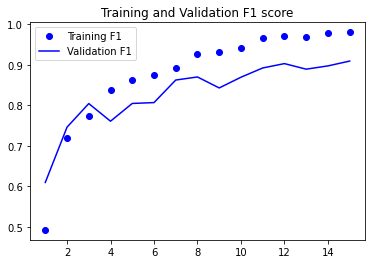

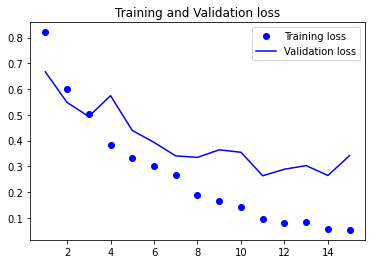

<Figure size 432x288 with 0 Axes>

In [53]:
plot_history(historyBW)


In [54]:
callbacks_BW_inc = callback("\modelBW_inc.h5")
#increase the nr of filters through the CNN

In [55]:
model2 = models.Sequential()

model2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model2.add(layers.MaxPooling2D(2, 2))
model2.add(layers.Conv2D(32, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D(2, 2))
model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D(2, 2))
model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D(2, 2))
model2.add(layers.Flatten())
model2.add(layers.Dense(100, activation='relu'))
model2.add(layers.Dense(3, activation='softmax'))

model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[f1_m])

history_2 = model2.fit_generator(train_generator, callbacks=callbacks_BW_inc, epochs=30, steps_per_epoch=123, validation_steps=16,
                                 validation_data=val_generator, workers=2)

Epoch 1/30
123/123 [==============================] - ETA: 0s - loss: 0.7821 - f1_m: 0.5629
Epoch 00001: val_loss improved from inf to 0.64189, saving model to c:\Users\Utilizador\Desktop\2_semestre_DS\Deep_Learning\DL_GroupProject\DeepLearning_Group_Project\models\modelBW_inc.h5
123/123 [==============================] - 66s 536ms/step - loss: 0.7821 - f1_m: 0.5629 - val_loss: 0.6419 - val_f1_m: 0.7159
Epoch 2/30
123/123 [==============================] - ETA: 0s - loss: 0.5613 - f1_m: 0.7450
Epoch 00002: val_loss improved from 0.64189 to 0.49001, saving model to c:\Users\Utilizador\Desktop\2_semestre_DS\Deep_Learning\DL_GroupProject\DeepLearning_Group_Project\models\modelBW_inc.h5
123/123 [==============================] - 72s 581ms/step - loss: 0.5613 - f1_m: 0.7450 - val_loss: 0.4900 - val_f1_m: 0.7882
Epoch 3/30
123/123 [==============================] - ETA: 0s - loss: 0.4478 - f1_m: 0.8084
Epoch 00003: val_loss did not improve from 0.49001
123/123 [==============================

In [56]:
np.save('models/historyBW_inc.npy',history_2.history)
modelBW_inc = keras.models.load_model('models/modelBW_inc.h5', custom_objects=dependencies)
historyBW_inc=np.load('models/historyBW_inc.npy',allow_pickle='TRUE').item()
timesBW = time_callback.times
save_times(modelBW_inc, timesBW,'modelBW_inc')

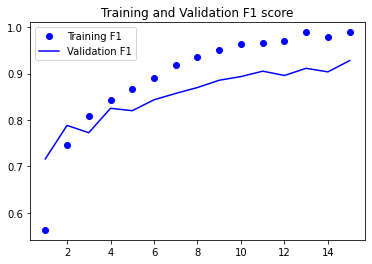

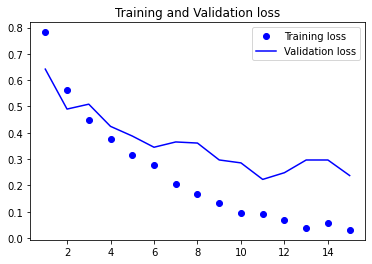

<Figure size 432x288 with 0 Axes>

In [57]:
plot_history(historyBW_inc)

# REDUCING THE NUMBER OF LAYERS

In [58]:
callbacks_BW_simple = callback("\modelBW_simple.h5")
#increase the nr of filters through the CNN

In [59]:
model3 = models.Sequential()

model3.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model3.add(layers.MaxPooling2D(2, 2))
model3.add(layers.Conv2D(64, (3, 3), activation='relu'))
model3.add(layers.MaxPooling2D(2, 2))
model3.add(layers.Conv2D(64, (3, 3), activation='relu'))
model3.add(layers.MaxPooling2D(2, 2))
model3.add(layers.Flatten())
model3.add(layers.Dense(100, activation='relu'))
model3.add(layers.Dense(3, activation='softmax'))

model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[f1_m])

history_3 = model3.fit_generator(train_generator, callbacks=callbacks_BW_simple, epochs=30, steps_per_epoch=123, validation_steps=16,
                                 validation_data=val_generator, workers=2)

Epoch 1/30
123/123 [==============================] - ETA: 0s - loss: 0.7221 - f1_m: 0.6164
Epoch 00001: val_loss improved from inf to 0.68303, saving model to c:\Users\Utilizador\Desktop\2_semestre_DS\Deep_Learning\DL_GroupProject\DeepLearning_Group_Project\models\modelBW_simple.h5
123/123 [==============================] - 81s 657ms/step - loss: 0.7221 - f1_m: 0.6164 - val_loss: 0.6830 - val_f1_m: 0.6612
Epoch 2/30
123/123 [==============================] - ETA: 0s - loss: 0.5392 - f1_m: 0.7424
Epoch 00002: val_loss improved from 0.68303 to 0.53808, saving model to c:\Users\Utilizador\Desktop\2_semestre_DS\Deep_Learning\DL_GroupProject\DeepLearning_Group_Project\models\modelBW_simple.h5
123/123 [==============================] - 77s 623ms/step - loss: 0.5392 - f1_m: 0.7424 - val_loss: 0.5381 - val_f1_m: 0.7250
Epoch 3/30
123/123 [==============================] - ETA: 0s - loss: 0.4233 - f1_m: 0.8077
Epoch 00003: val_loss improved from 0.53808 to 0.52782, saving model to c:\Users\Uti

In [60]:
np.save('models/historyBW_simple.npy',history_3.history)
modelBW_simple = keras.models.load_model('models/modelBW_simple.h5', custom_objects=dependencies)
historyBW_simple=np.load('models/historyBW_simple.npy',allow_pickle='TRUE').item()
timesBW_simple = time_callback.times

save_times(modelBW_simple, timesBW_simple,'modelBW_simple')

# DATA AUGMENTATION AND DROP OUT 0.5

In [16]:
def callback(filename):
      callname_list=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3),
            keras.callbacks.ModelCheckpoint(filepath=os.path.join(base_path+ "\models")+filename, monitor='val_loss',mode='min',verbose=1, save_best_only=True),
            time_callback, 
            keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, mode='min', min_lr=1e-4)]

      return callname_list


In [17]:
callbacks_BW_aug_5 = callback("\modelBW_aug_5.h5")
# aug and dropout
# modelBW_aug_rot= rotation10
# modelBW_aug=rot50

In [18]:
model4 = models.Sequential()

model4.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model4.add(layers.MaxPooling2D(2, 2))
model4.add(layers.Conv2D(64, (3, 3), activation='relu'))
model4.add(layers.MaxPooling2D(2, 2))
model4.add(layers.Conv2D(64, (3, 3), activation='relu'))
model4.add(layers.MaxPooling2D(2, 2))
model4.add(layers.Flatten())
model4.add(layers.Dropout(0.5))
model4.add(layers.Dense(100, activation='relu'))
model4.add(layers.Dense(3, activation='softmax'))

model4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[f1_m])

history_4 = model4.fit_generator(train_generator_aug, callbacks=callbacks_BW_aug_5, epochs=30, steps_per_epoch=123, validation_steps=16,
                                 validation_data=val_generator, workers=2)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
123/123 [==============================] - ETA: 0s - loss: 0.7707 - f1_m: 0.5844
Epoch 00001: val_loss improved from inf to 0.60630, saving model to c:\Users\Utilizador\Desktop\2_semestre_DS\Deep_Learning\DL_GroupProject\DeepLearning_Group_Project\models\modelBW_aug_5.h5
123/123 [==============================] - 85s 688ms/step - loss: 0.7707 - f1_m: 0.5844 - val_loss: 0.6063 - val_f1_m: 0.7426
Epoch 2/30
123/123 [==============================] - ETA: 0s - loss: 0.5832 - f1_m: 0.7324
Epoch 00002: val_loss improved from 0.60630 to 0.49565, saving model to c:\Users\Utilizador\Desktop\2_semestre_DS\Deep_Learning\DL_GroupProject\DeepLearning_Group_Project\models\modelBW_aug_5.h5
123/123 [==============================] - 85s 688ms/step - loss: 0.5832 - f1_m: 0.7324 - val_loss: 0.4957 - val_f1_m: 0.7823
Epoch 3/30
123/123 [==============================] - ETA: 0s - loss: 0.4590 - f1_m: 0.7996
Epoch 0000

In [19]:
#np.save('models/historyBW_aug_5.npy',history_4.history)
modelBW_aug_5 = keras.models.load_model('models/modelBW_aug_5.h5', custom_objects=dependencies)
historyBW_aug_5=np.load('models/historyBW_aug_5.npy',allow_pickle='TRUE').item()
#timesBW_aug_5 = time_callback.times
#save_times(modelBW_aug_5, timesBW_aug_5,'modelBW_aug_5')

In [20]:
preds = modelBW_aug_5.predict(test_generator)
predicted_class_indices = np.argmax(preds, axis=1)
test_labels = test_generator.labels

cm = confusion_matrix(test_labels, predicted_class_indices)
test_score = modelBW_aug_5.evaluate_generator(test_generator)
cm

Instructions for updating:
Please use Model.evaluate, which supports generators.


array([[ 68,   2,   1],
       [  7, 134,   1],
       [  0,   0,  93]], dtype=int64)

In [21]:
print(f'Test loss: {test_score[0]} / Test accuracy: {test_score[1]}')

Test loss: 0.10719911754131317 / Test accuracy: 0.965624988079071


# DATA AUGMENTATION AND DROP OUT 0.3

In [96]:
callbacks_BW_aug_3 = callback("\modelBW_aug_3.h5")
# aug and dropout of 0.3
# modelBW_aug=rot50

In [97]:
model5 = models.Sequential()

model5.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model5.add(layers.MaxPooling2D(2, 2))
model5.add(layers.Conv2D(64, (3, 3), activation='relu'))
model5.add(layers.MaxPooling2D(2, 2))
model5.add(layers.Conv2D(64, (3, 3), activation='relu'))
model5.add(layers.MaxPooling2D(2, 2))
model5.add(layers.Flatten())
model5.add(layers.Dropout(0.3))
model5.add(layers.Dense(100, activation='relu'))
model5.add(layers.Dense(3, activation='softmax'))

model5.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[f1_m])

history_5 = model5.fit_generator(train_generator_aug, callbacks=callbacks_BW_aug_3, epochs=30, steps_per_epoch=123, validation_steps=16,
                                 validation_data=val_generator, workers=2)

Epoch 1/30
123/123 [==============================] - ETA: 0s - loss: 0.7330 - f1_m: 0.6117
Epoch 00001: val_loss improved from inf to 0.66092, saving model to c:\Users\Utilizador\Desktop\2_semestre_DS\Deep_Learning\DL_GroupProject\DeepLearning_Group_Project\models\modelBW_aug_3.h5
123/123 [==============================] - 73s 592ms/step - loss: 0.7330 - f1_m: 0.6117 - val_loss: 0.6609 - val_f1_m: 0.6600
Epoch 2/30
123/123 [==============================] - ETA: 0s - loss: 0.5207 - f1_m: 0.7690
Epoch 00002: val_loss improved from 0.66092 to 0.46974, saving model to c:\Users\Utilizador\Desktop\2_semestre_DS\Deep_Learning\DL_GroupProject\DeepLearning_Group_Project\models\modelBW_aug_3.h5
123/123 [==============================] - 80s 649ms/step - loss: 0.5207 - f1_m: 0.7690 - val_loss: 0.4697 - val_f1_m: 0.8069
Epoch 3/30
123/123 [==============================] - ETA: 0s - loss: 0.4352 - f1_m: 0.8097
Epoch 00003: val_loss improved from 0.46974 to 0.44493, saving model to c:\Users\Utili

In [98]:
#np.save('models/historyBW_aug_3.npy',history_5.history)
modelBW_aug_3 = keras.models.load_model('models/modelBW_aug_3.h5', custom_objects=dependencies)
historyBW_aug_3=np.load('models/historyBW_aug_3.npy',allow_pickle='TRUE').item()
#timesBW_aug_3 = time_callback.times
#save_times(modelBW_aug_3, timesBW_aug_3,'modelBW_aug_3')

# DATA AUGMENTATION AND DROP OUT 0.4 

In [103]:
callbacks_BW_aug_4 = callback("\modelBW_aug_4.h5")

In [104]:
def create_model_drop(input_drop):
    model = models.Sequential()

    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
    model.add(layers.MaxPooling2D(2, 2))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(2, 2))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(2, 2))
    model.add(layers.Flatten())
    model.add(layers.Dropout(input_drop))
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(3, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[f1_m])

    history = model.fit_generator(train_generator_aug, callbacks=callbacks_BW_aug_4, epochs=30, steps_per_epoch=123, validation_steps=16,
                                    validation_data=val_generator, workers=2)
    return history

In [105]:
history_6=create_model_drop(0.4)

Epoch 1/30
123/123 [==============================] - ETA: 0s - loss: 0.7503 - f1_m: 0.6051
Epoch 00001: val_loss improved from inf to 0.69886, saving model to c:\Users\Utilizador\Desktop\2_semestre_DS\Deep_Learning\DL_GroupProject\DeepLearning_Group_Project\models\modelBW_aug_4.h5
123/123 [==============================] - 86s 702ms/step - loss: 0.7503 - f1_m: 0.6051 - val_loss: 0.6989 - val_f1_m: 0.7055
Epoch 2/30
123/123 [==============================] - ETA: 0s - loss: 0.5600 - f1_m: 0.7487
Epoch 00002: val_loss improved from 0.69886 to 0.54631, saving model to c:\Users\Utilizador\Desktop\2_semestre_DS\Deep_Learning\DL_GroupProject\DeepLearning_Group_Project\models\modelBW_aug_4.h5
123/123 [==============================] - 84s 684ms/step - loss: 0.5600 - f1_m: 0.7487 - val_loss: 0.5463 - val_f1_m: 0.7568
Epoch 3/30
123/123 [==============================] - ETA: 0s - loss: 0.4462 - f1_m: 0.8076
Epoch 00003: val_loss improved from 0.54631 to 0.50075, saving model to c:\Users\Utili

In [106]:
np.save('models/historyBW_aug_4.npy',history_6.history)
modelBW_aug_4 = keras.models.load_model('models/modelBW_aug_4.h5', custom_objects=dependencies)
historyBW_aug_4=np.load('models/historyBW_aug_4.npy',allow_pickle='TRUE').item()
timesBW_aug_4 = time_callback.times
save_times(modelBW_aug_4, timesBW_aug_4,'modelBW_aug_4')

# DATA AUGMENTATION AND regularization L1

In [93]:
callbacks_BW_aug_l1 = callback("\modelBW_aug_l1.h5")
# modelBW_aug=rot50

In [94]:
model7 = models.Sequential()

model7.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model7.add(layers.MaxPooling2D(2, 2))
model7.add(layers.Conv2D(64, (3, 3), activation='relu'))
model7.add(layers.MaxPooling2D(2, 2))
model7.add(layers.Conv2D(64, (3, 3), activation='relu'))
model7.add(layers.MaxPooling2D(2, 2))
model7.add(layers.Flatten())
model7.add(layers.Dropout(0.5))
model7.add(layers.Dense(100, activation='relu', kernel_regularizer=keras.regularizers.l1(1e-4)))
model7.add(layers.Dense(3, activation='softmax'))

model7.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[f1_m])

history_7 = model7.fit_generator(train_generator_aug, callbacks=callbacks_BW_aug_l1, epochs=30, steps_per_epoch=123, validation_steps=16,
                                 validation_data=val_generator, workers=2)

Epoch 1/30
123/123 [==============================] - ETA: 0s - loss: 1.1510 - f1_m: 0.5694
Epoch 00001: val_loss improved from inf to 1.13698, saving model to c:\Users\Utilizador\Desktop\2_semestre_DS\Deep_Learning\DL_GroupProject\DeepLearning_Group_Project\models\modelBW_aug_l1.h5
123/123 [==============================] - 82s 665ms/step - loss: 1.1510 - f1_m: 0.5694 - val_loss: 1.1370 - val_f1_m: 0.7161
Epoch 2/30
123/123 [==============================] - ETA: 0s - loss: 0.8730 - f1_m: 0.6908
Epoch 00002: val_loss improved from 1.13698 to 0.77076, saving model to c:\Users\Utilizador\Desktop\2_semestre_DS\Deep_Learning\DL_GroupProject\DeepLearning_Group_Project\models\modelBW_aug_l1.h5
123/123 [==============================] - 79s 641ms/step - loss: 0.8730 - f1_m: 0.6908 - val_loss: 0.7708 - val_f1_m: 0.7325
Epoch 3/30
123/123 [==============================] - ETA: 0s - loss: 0.7720 - f1_m: 0.7526
Epoch 00003: val_loss did not improve from 0.77076
123/123 [========================

In [95]:
#np.save('models/historyBW_aug_l1.npy',history_7.history)
modelBW_aug_l1 = keras.models.load_model('models/modelBW_aug_l1.h5', custom_objects=dependencies)
historyBW_aug_l1=np.load('models/historyBW_aug_l1.npy',allow_pickle='TRUE').item()
#timesBW_aug_l1 = time_callback.times
#save_times(modelBW_aug_l1, timesBW_aug_l1,'modelBW_aug_l1')

# TRANSFER LEARNING

In [53]:
# pre_trained=tf.keras.applications.ResNet50(
#                                                     include_top=True,
#                                                     input_shape=(224,224,1),
#                                                     weights='imagenet',
#                                                     input_tensor=None,
                                               
#                                                     pooling=None,
#                                                     classes=1000
#                                                 )

In [19]:
callbacks_trans = callback("\model_trans.h5")

In [26]:
from keras.models import Model
base_model=tf.keras.applications.ResNet50(include_top=False, weights="imagenet",input_shape=(150,150,3), pooling='max') 
x=base_model.output
x=layers.Dropout(0.4)(x) 
#x = layers.Dense(100,activation='relu')(x)     
output=layers.Dense(3, activation='softmax')(x)
model_trans=Model(inputs=base_model.input, outputs=output)
model_trans.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[f1_m]) 

In [27]:
history_trans = model_trans.fit_generator(train_generator_aug_rgb, callbacks=callbacks_trans, epochs=30, steps_per_epoch=123, validation_steps=16,
                                 validation_data=val_generator_rgb, workers=2)

Epoch 1/30
123/123 [==============================] - ETA: 0s - loss: 2.3859 - f1_m: 0.6882
Epoch 00001: val_loss improved from inf to 187213.20312, saving model to c:\Users\Utilizador\Desktop\2_semestre_DS\Deep_Learning\DL_GroupProject\DeepLearning_Group_Project\models\model_trans.h5
123/123 [==============================] - 1118s 9s/step - loss: 2.3859 - f1_m: 0.6882 - val_loss: 187213.2031 - val_f1_m: 0.4701
Epoch 2/30
123/123 [==============================] - ETA: 0s - loss: 1.2509 - f1_m: 0.6791
Epoch 00002: val_loss improved from 187213.20312 to 58592.59766, saving model to c:\Users\Utilizador\Desktop\2_semestre_DS\Deep_Learning\DL_GroupProject\DeepLearning_Group_Project\models\model_trans.h5
123/123 [==============================] - 1112s 9s/step - loss: 1.2509 - f1_m: 0.6791 - val_loss: 58592.5977 - val_f1_m: 0.4701
Epoch 3/30
 18/123 [===>..........................] - ETA: 14:07 - loss: 0.5297 - f1_m: 0.7475

KeyboardInterrupt: 

In [58]:
base_model = keras.applications.ResNet50(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

base_model.trainable = False
inputs = keras.Input(shape=(150, 150, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(3)(x)
model = keras.Model(inputs, outputs)
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics = [f1_m])

In [34]:
from keras.models import Model
from keras.layers import Input 

resnet = keras.applications.ResNet50(weights='imagenet',include_top='FALSE') 

input_tensor = Input(shape=(150,150,1) )
x = layers.Conv2D(3,(3,3),padding='same')(input_tensor)    # x has a dimension of (IMG_SIZE,IMG_SIZE,3)
out = resnet (x) 

model_trans = keras.Model(inputs=input_tensor,outputs=out)


base_model.trainable = False
inputs = keras.Input(shape=(150, 150, 1))
x = base_model(inputs, training=False)
x = keras.layers.GlobalMaxPooling2D()(x)
outputs = keras.layers.Dense(3)(x)
model_trans = keras.Model(inputs, outputs)


In [109]:
#pip install torchvision

In [60]:
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics = [f1_m])
hist_trans = model.fit(train_generator_aug_rgb,
                    epochs = 20,
                    validation_data = val_generator_rgb,
                    callbacks=callbacks_trans, workers=2)

Epoch 1/20
123/123 [==============================] - ETA: 0s - loss: 12.3960 - f1_m: 0.3031
Epoch 00001: val_loss improved from inf to 12.39046, saving model to c:\Users\Utilizador\Desktop\2_semestre_DS\Deep_Learning\DL_GroupProject\DeepLearning_Group_Project\models\model_trans.h5
123/123 [==============================] - 166s 1s/step - loss: 12.3960 - f1_m: 0.3031 - val_loss: 12.3905 - val_f1_m: 0.3022
Epoch 2/20
123/123 [==============================] - ETA: 0s - loss: 12.3960 - f1_m: 0.3034
Epoch 00002: val_loss improved from 12.39046 to 12.39046, saving model to c:\Users\Utilizador\Desktop\2_semestre_DS\Deep_Learning\DL_GroupProject\DeepLearning_Group_Project\models\model_trans.h5
123/123 [==============================] - 167s 1s/step - loss: 12.3960 - f1_m: 0.3034 - val_loss: 12.3905 - val_f1_m: 0.3022
Epoch 3/20
 24/123 [====>.........................] - ETA: 2:08 - loss: 12.6258 - f1_m: 0.3104

KeyboardInterrupt: 

In [42]:

from keras.models import Model
from keras.layers import Input 

resnet = keras.applications.ResNet50(weights='imagenet',include_top= 'TRUE') 

input_tensor = Input(shape=(224,224,1) )
x = keras.layers.Conv2D(3,(3,3),padding='same')(input_tensor)    # x has a dimension of (IMG_SIZE,IMG_SIZE,3)
x = keras.layers.Dense(3)(x)
out = resnet (x) 

model = Model(inputs=input_tensor,outputs=out)

In [73]:
preds = modelBW.predict(test_generator)
predicted_class_indices = np.argmax(preds, axis=1)
test_labels = test_generator.labels

cm = confusion_matrix(test_labels, predicted_class_indices)
test_score = modelBW.evaluate_generator(test_generator)

C:\Users\filip\AppData\Local\Temp/ipykernel_7176/1856620179.py:6: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_score = modelBW.evaluate_generator(test_generator)


In [74]:
print(classification_report(test_generator.labels, predicted_class_indices))

              precision    recall  f1-score   support

           0       0.94      0.83      0.88        71
           1       0.92      0.97      0.95       142
           2       0.97      0.97      0.97        93

    accuracy                           0.94       306
   macro avg       0.94      0.92      0.93       306
weighted avg       0.94      0.94      0.94       306



In [ ]:
#modelBW.summary()

In [ ]:
# test_score_modelBW = modelBW.evaluate_generator(test_generator)
# test_score_modelBW

In [ ]:
# Modelo sem aug BW
#  ---- dropout augmentation

# Modelo sem aug RGB
#  ---- dropout augmentation

# funçoes dos plots

# time function comparison